In [1]:
# 1 // Prepare the Dataset

# import libraries  
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

# Define batch size
BATCH_SIZE = 64
PREFETCH_SIZE = 2

# Preprocess the dataset
def data_pipeline(input):
    # Map the dataset to extract images and labels
    input =input.map(lambda image, label: (image, label))
    # Reshape each image to a flat vector
    input = input.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # Normalize(Scale) image values to be in the range [-1, 1]
    input = input.map(lambda image, label: ((tf.cast(image, tf.float32) / 255) - 1, label))
    # One-hot encode the labels
    input = input.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    # Decode one-hot labels and convert images to numpy arrays for visualization
    input = input.map(lambda image, label: (image, tf.argmax(label, axis=-1)))
    # Shuffle the dataset and create batches of size 4
    input = input.shuffle(1024).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
    return input

# Save the datasets after applying the data pipeline
train_dataset = data_pipeline(ds_train)
test_dataset = data_pipeline(ds_test)

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Plot the dataset
def plot_dataset(dataset, num_images=9):
    # Take a single batch from the dataset
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            # Reshape the image to 32x32x3
            img = images[i].numpy().reshape(32, 32, 3)
            # Rescale the image back to the range [0, 1] for visualization
            img = (img + 1) / 2
            plt.subplot(3, 3, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title("Label: {}".format(labels[i]))
            plt.axis('off')
        plt.show()

# Assuming we already define everything
plot_dataset(train_dataset)


NameError: name 'cifar10' is not defined

Training set size: (50000, 32, 32, 3)
Test set size: (10000, 32, 32, 3)
Each image size: (32, 32, 3)
Number of classes: 10
Sample labels: [[6]
 [9]
 [9]
 [4]
 [1]]
Train set distribution: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Test set distribution: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


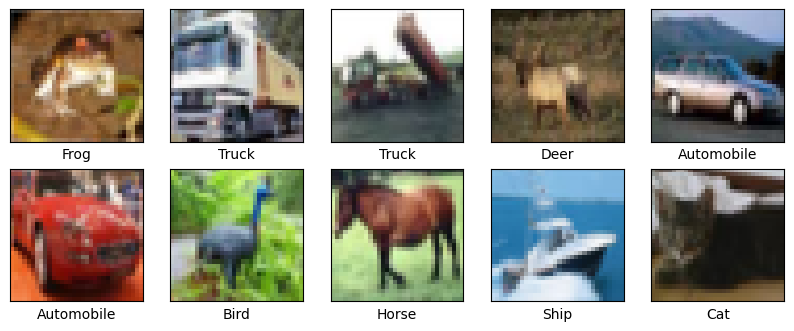

In [1]:
# import required libraries  
# import libraries  
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt


# // PREPROCESSING THE DATASET
def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    (train_ds, test_ds) = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img/128) - 1            
        label = tf.one_hot(label, depth=10)
        return img, label
    
    train_ds = train_ds.map(lambda img, label: preprocessing_func(img, label))
    train_ds = train_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    
    test_ds = test_ds.map(lambda img, label: preprocessing_func(img, label))
    test_ds = test_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    return train_ds, test_ds


SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_ds, test_ds = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

# // DEFINE THE HYPERPARAMETERS



In [3]:
# // 1.2 The CNN Model

# 1.2 Build the CNN Model
def build_model(input_shape, num_classes, conv_layers_config, dense_units, dropout_rate):
    input_tensor = Input(shape=input_shape)

    x = input_tensor
    for layer_conf in conv_layers_config:
        x = Conv2D(layer_conf['filters'], layer_conf['kernel_size'], activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    for units in dense_units:
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Model Configuration
input_shape = (32, 32, 3)
num_classes = 10
conv_layers_config = [{'filters': 32, 'kernel_size': (3, 3)}, {'filters': 64, 'kernel_size': (3, 3)}]
dense_units = [128]
dropout_rate = 0.5
epochs = 15



In [6]:
def train_and_evaluate(num_epochs, batch_size, shuffle_buffer_size, lr):
    model = build_model(input_shape, num_classes, conv_layers_config, dense_units, dropout_rate)
    data = load_and_prep_cifar(batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    loss_f = tf.keras.losses.CategoricalCrossentropy()
  
    train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

    for epoch in range(num_epochs):
        # Training phase
        epoch_train_loss = 0.0
        for x_train, target_train in train_ds:
            with tf.GradientTape() as tape:
                pred_train = model(x_train)
                loss_train = loss_f(target_train, pred_train)

            gradients_train = tape.gradient(loss_train, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients_train, model.trainable_variables))
            
            epoch_train_loss += loss_train

        train_accuracy_metric.reset_states()
        for x_train, target_train in train_ds:
            pred_train = model(x_train)
            train_accuracy_metric.update_state(target_train, pred_train)

        # Testing phase
        epoch_test_loss = 0.0
        for x_test, target_test in test_ds:
            pred_test = model(x_test)
            loss_test = loss_f(target_test, pred_test)
            epoch_test_loss += loss_test

        test_accuracy_metric.reset_states()
        for x_test, target_test in test_ds:
            pred_test = model(x_test)
            test_accuracy_metric.update_state(target_test, pred_test)

        # Calculate and print metrics
        average_train_loss = epoch_train_loss / len(test_ds)
        average_test_loss = epoch_test_loss / len(test_ds)
        train_accuracy = train_accuracy_metric.result()
        test_accuracy = test_accuracy_metric.result()

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4%}, "
              f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4%}")

# Define your hyperparameters
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
NUM_EPOCHS = 15
LR = 0.001

# Call the training and evaluation function
train_and_evaluate(NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)

In [7]:
# // 1.3 Training the Model ((((only training loop)))
# Define a training loop function. 
def train(num_epochs, batch_size, shuffle_buffer_size, lr):
    model = build_model(input_shape, num_classes, conv_layers_config, dense_units, dropout_rate)
    data = load_and_prep_cifar(batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    loss_f = tf.keras.losses.CategoricalCrossentropy()
  
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for x, target in data:
            with tf.GradientTape() as tape:
                pred = model(x)
                l = loss_f(target, pred)
            gradients = tape.gradient(l, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Update the accuracy metric
            accuracy_metric.update_state(target, pred)
            
            # Update epoch loss
            epoch_loss += l
            
        # Calculate epoch-level metrics
        epoch_accuracy = accuracy_metric.result()
        average_epoch_loss = epoch_loss / len(data)
        
        # Print epoch-level metrics
        print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {average_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4%}")
        
        # Reset the state for the next epoch
        accuracy_metric.reset_states()

        
        
# Define your hyperparameters, 
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
NUM_EPOCHS=15
LR = 0.001

# think of an appropriate loss function and optimizer and initialize everything. 
# Store loss and accuracy for training and test data. 
# Training your network for a maximum of 15 epochs should be enough

train(NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LR)

